# COSMOS Catalogue

In this notebook, I create a processed catalogue from the COSMOS 2020 catalogue downloaded from https://cosmos2020.calet.org/catalogues/.

The steps are based on the explanation in the official notebook at https://github.com/cosmic-dawn/cosmos2020-readcat/blob/main/COSMOS2020_readcat.ipynb.

More information can be found in the Catalogue Paper https://iopscience.iop.org/article/10.3847/1538-4365/ac3078/pdf or in the summary https://cosmos2020.calet.org/catalogues/COSMOS2020-ESOP3-24.6.22.pdf.

In [1]:
%matplotlib inline 
import numpy as np 
from matplotlib import pyplot as plt 
import h5py # used in the Data Visualization section 

from astropy.io import fits,ascii,votable
from astropy import units as u 
from astropy import constants as const
from astropy import table
from astropy.cosmology import Planck15,FlatLambdaCDM

# For ML application
from sklearn.cluster import KMeans
from sklearn import mixture
from itertools import combinations



/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='

In [2]:
# Specify the version of the catalog and the folder with the input/output files
catversion = 'Classic'  # this string can be either 'Classic' or 'Farmer'
dir_in = '/Users/philipp/Documents/PhD/Data/'  
dir_out = '/Users/philipp/Documents/PhD/Data/'  # the directory where the output of this notebook will be stored

In [3]:
# Chose the SED fitting code: 
# set to 'lp' for LePhare results or
# set to 'ez' for EAZY
fitversion = 'ez'

In [4]:
# Which type of photometric estimates to use? (suffix of the column name)
# This choice must be consistent with `catversion`,
# choices for Classic are: '_FLUX_APER2', '_FLUX_APER3', '_MAG_APER2,', '_MAG_APER3'
# choices for Farmer are '_FLUX' or '_MAG' 
flx = '_FLUX_APER3'  
flxerr = '_FLUXERR_APER3'# catalog column for flux/mag error, just add 'ERR'
mg = '_MAG_APER3'
mgerr = '_MAGERR_APER3'
# flx = '_FLUX'  
# flxerr = '_FLUXERR'# catalog column for flux/mag error, just add 'ERR'
# mg = '_MAG'
# mgerr = '_MAGERR'
outflx = 'cgs' # 'cgs' or 'uJy'

In [5]:
# Filter names, mean wavelength, and other info (see Table 1 in W+21)
filt_name = ['GALEX_FUV', 'GALEX_NUV','CFHT_u','CFHT_ustar','HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 
             'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'SC_IB427', 'SC_IB464', 'SC_IA484', 'SC_IB505', 
             'SC_IA527', 'SC_IB574', 'SC_IA624', 'SC_IA679', 'SC_IB709', 'SC_IA738', 'SC_IA767', 'SC_IB827', 
             'SC_NB711', 'SC_NB816', 'UVISTA_NB118', 'SC_B', 'SC_gp', 'SC_V', 'SC_rp', 'SC_ip','SC_zp', 'SC_zpp', 
             'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3','IRAC_CH4']  
filt_lambda = [0.1526,0.2307,0.3709,0.3858,0.4847,0.6219,0.7699,0.8894,0.9761,1.0216,1.2525,1.6466,2.1557,0.4266,
               0.4635,0.4851,0.5064,0.5261,0.5766,0.6232,0.6780,0.7073,0.7361,0.7694,0.8243,0.7121,0.8150,1.1909,
               0.4488,0.4804,0.5487,0.6305,0.7693,0.8978,0.9063,3.5686,4.5067,5.7788,7.9958]
filt_fwhm = [0.0224,0.07909,0.05181,0.05976,0.1383,0.1547,0.1471,0.0766,0.0786,0.0923,0.1718,0.2905,0.3074,
             0.02073,0.02182,0.02292,0.0231,0.02429,0.02729,0.03004,0.03363,0.03163,0.03235,0.03648,0.0343,0.0072,
             0.01198,0.01122,0.0892,0.1265,0.0954,0.1376,0.1497,0.0847,0.1335,0.7443,1.0119,1.4082,2.8796] 
# corresponding MW attenuation from Schelgel 
AlambdaDivEBV = [8.31,8.742,4.807,4.674,3.69,2.715,2.0,1.515,1.298,1.213,0.874,0.565,0.365,4.261,3.844,3.622,
                 3.425,3.265,2.938,2.694,2.431,2.29,2.151,1.997,1.748,2.268,1.787,0.946,4.041,3.738,3.128,2.673,
                 2.003,1.436,1.466,0.163,0.112,0.075,0.045]
# photometric offsets (not available for all filters, see Table 3 in W+21)
## CAREFUL: I don't see where they match
zpoff1 = [0.000,-0.352,-0.077,-0.023,0.073,0.101,0.038,0.036,0.086,0.054,0.017,-0.045,0.000,-0.104,-0.044,-0.021,
          -0.018,-0.045,-0.084,0.005,0.166,-0.023,-0.034,-0.032,-0.069,-0.010,-0.064,0.000,0.000,0.000,0.000,
          0.000,0.000,0.000,0.000,-0.212,-0.219,0.000,0.000]  # Farmer+LePhare
zpoff2 = [0.000,-0.029,-0.006,0.053,0.128,0.127,0.094,0.084,0.100,0.049,0.025,-0.044,0.000,-0.013,-0.008,0.022,
          0.025,0.033,-0.032,0.031,0.208,-0.009,0.003,-0.015,-0.001,0.023,-0.021,-0.017,-0.075,0.000,0.123,0.035,
          0.051,0.000,0.095,-0.087,-0.111,0.000,0.000]  # Classic+LePhare
zpoff3 = [0.000,0.000,-0.196,-0.054,0.006,0.090,0.043,0.071,0.118,0.078,0.047,-0.034,0.000,-0.199,-0.129,-0.084,
          -0.073,-0.087,-0.124,0.004,0.154,-0.022,-0.030,-0.013,-0.057,0.000,0.000,0.000,0.000,0.000,0.000,0.000,
          0.000,0.000,0.000,-0.102,-0.044,0.000,0.000] # Farmer+EAZY
zpoff4 = [0.000,0.000,0.000,-0.021,0.055,0.124,0.121,0.121,0.145,0.085,0.057,-0.036,0.000,-0.133,-0.098,-0.046,
          -0.037,-0.038,-0.062,0.038,0.214,0.024,0.022,0.01,0.022,0.000,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,
          0.00,0.021,0.025,0.000,0.000] # Classic+EAZY
# create the dictionary
filt_dict = {filt_name[i]:(filt_lambda[i]*1e4,filt_fwhm[i]*1e4,AlambdaDivEBV[i],
                           [zpoff1[i],zpoff2[i],zpoff3[i],zpoff4[i]]) for i in range(len(filt_name))}

In [6]:
# Upload the main catalogue
cat0 = table.Table.read(dir_in+f'COSMOS2020_{catversion.upper()}_R1_v2.1_p3.fits',format='fits',hdu=1)

In [7]:
# Create a mask to restrict the analysis to a subset of filters (optional)
filt_use = ['HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_Y', 'UVISTA_J', 
            'UVISTA_H', 'UVISTA_Ks', 'SC_B']
filt_mask = [i in filt_use for i in filt_name]

In [8]:
whichflag = 'COMBINED'  # you can try HSC, SUPCAM, UVISTA, UDEEP, COMBINED
print('The parent sample includes {} sources'.format(len(cat0)))
cat0 = cat0[cat0['FLAG_{}'.format(whichflag)]==0]
print('Now restricted to {} sources by using FLAG_COMBINED'.format(len(cat0)))

The parent sample includes 1720700 sources
Now restricted to 723897 sources by using FLAG_COMBINED


### Correcting for MW extinction

In [9]:
def mw_corr(tab_in,f_dict,ebv_col='EBV_MW',flx_col='_FLUX',flxerr_col='_FLUXERR',
            only_filt=[],skip_filt=[],verbose=False,out=False):
    """
    Parameters
    ----------
    tab_in : astropy table of COSMOS2020
    f_dict : dictionary with filter info
    ebv_col : name of the `tab_in` column containing the E(B-V) from Milky Way
    flx_col : name of the `tab_in` column containing the flux
    flxerr_col : name of the `tab_in` column containing the flux error bar
    only_filt : list of the filters to be processed (filter names as in `f_dict`)
    skip_filt : list of the filters NOT to be processed (filter names as in `f_dict`)
    verbose : if True, print a verbose output
    out : if True, return a new table with the changes; if False, overwrite `tab_in`
    """
    
    if 'FLUX' in flx_col: flux=True
    else: flux=False
    if out: tab = tab_in.copy()
    else: tab = tab_in
    ff = f_dict.keys()
    if len(only_filt)>0 : ff = only_filt
    for c in ff:
        if verbose: print('remove MW attenuation in ',c+flx_col,f_dict[c][2])
        if c not in skip_filt:
            atten = f_dict[c][2]*tab[ebv_col]
            if flux:    tab[c+flx_col] *= np.power(10.,0.4*atten)
            else:    tab[c+flx_col] -= atten             
        else:
            if verbose: print('Skip filter',c)       
    if out: return tab

In [10]:
# Here, the function creates a new table but
# it is also possible to overwrite the original table `cat0`
if catversion.lower()=='classic' and flx!='_FLUX' and flx!='_MAG':  
    # it means you are using aperture or AUTO flux/mag, which are not available for IRAC and GALEX 
    cat1 = mw_corr(cat0,filt_dict,flx_col=flx,flxerr_col=flxerr,
                   only_filt=filt_use,skip_filt=['IRAC_CH1', 'IRAC_CH2', 'GALEX_FUV', 'GALEX_NUV'],
                   out=True) # fluxes are  in uJy (zero point = 23.9)
    # therefore, IRAC and GALEX have to be taken into account separately:
    mw_corr(cat1,filt_dict,flx_col='_FLUX',flxerr_col='_FLUXERR',
            only_filt=['IRAC_CH1', 'IRAC_CH2', 'GALEX_FUV', 'GALEX_NUV']) 
else:
    # otherwise, all filters have the same suffix
    cat1 = mw_corr(cat0,filt_dict,flx_col=flx,flxerr_col=flxerr,only_filt=filt_use,out=True)  # all bands have same column suffix

### Correcting for aperture-to-total flux

In [11]:
def aper_to_tot(tab_in,f_dict,flx_col='_FLUX',flxerr_col='_FLUXERR',scale_col='',out_col=None,only_filt=[],skip_filt=[],verbose=False,out=False):
    """
    Parameters
    ----------
    tab_in : astropy table of COSMOS2020
    f_dict : dictionary with filter info 
    flx_col : name of the `tab_in` column containing the flux
    flxerr_col : name of the `tab_in` column containing the flux error bar
    scale_col : name of the `tab_in` column containing the aper-to-total correction
    out_col : if defined, the rescaled photometry will be saved in a new column (otherwise it overwrites `flx_col`)
    only_filt : list of the filters to be processed (filter names as in `f_dict`)
    skip_filt : list of the filters NOT to be processed (filter names as in `f_dict`)
    verbose : if True, print a verbose output
    out : if True, return a new table with the changes; if False, overwrite `tab_in`  
    """
    
    if 'FLUX' in flx_col: flux=True
    else: flux=False
    if out: tab = tab_in.copy()
    else: tab = tab_in 
    ff = f_dict.keys()
    if len(only_filt)>0 : ff = only_filt
    for c in ff:
        if c not in skip_filt:

            if verbose and flux: print('rescale {} to total flux'.format(c+flx_col))
            if verbose and not flux: print('rescale {} to total mag'.format(c+flx_col))

            if flux:
                resc = np.power(10.,-0.4*tab[scale_col])
                if out_col:
                    tab[c+out_col] = tab[c+flx_col] * resc
                    tab[c+out_col+'ERR'] = tab[c+flxerr_col] * resc  # rescale also error bars not to alter the S/N ratio
                else:
                    tab[c+flx_col] *= resc
                    tab[c+flxerr_col] *= resc
            else:
                if out_col:
                    tab[c+out_col] = tab[c+flx_col] + tab[scale_col] 
                else:
                    tab[c+flx_col] += tab[scale_col]             
        else:
            if verbose: print('Skip filter',c)       
    if out: return tab
    

In [12]:
# Can be applied only to aperture photometry (not to AUTO or Farmer)
if (flx[-1]=='2' or flx[-1]=='3'):
    aper_to_tot(cat1,filt_dict,flx_col=flx,flxerr_col=flxerr,out_col='_FLUX',
    only_filt=filt_use,skip_filt=['IRAC_CH1', 'IRAC_CH2', 'GALEX_FUV', 'GALEX_NUV'],
    scale_col='total_off'+flx[-1],verbose=True)


rescale HSC_g_FLUX_APER3 to total flux
rescale HSC_r_FLUX_APER3 to total flux
rescale HSC_i_FLUX_APER3 to total flux
rescale HSC_z_FLUX_APER3 to total flux
rescale HSC_y_FLUX_APER3 to total flux
rescale UVISTA_Y_FLUX_APER3 to total flux
rescale UVISTA_J_FLUX_APER3 to total flux
rescale UVISTA_H_FLUX_APER3 to total flux
rescale UVISTA_Ks_FLUX_APER3 to total flux
rescale SC_B_FLUX_APER3 to total flux


### Correcting for photometric offset

In [13]:
def photo_corr(tab_in,f_dict,versions=('Farmer','lp'),flx_col='_FLUX',only_filt=[],
               skip_filt=[],verbose=False,out=False):
    """
    Parameters
    ----------
    tab_in : astropy table of COSMOS2020
    f_dict : dictionary with filter info
    ebv_col : name of the `tab_in` column containing the E(B-V) from Milky Way
    flx_col : name of the `tab_in` column containing the flux
    flxerr_col : name of the `tab_in` column containing the flux error bar
    only_filt : list of the filters to be processed (filter names as in `f_dict`)
    skip_filt : list of the filters NOT to be processed (filter names as in `f_dict`)
    verbose : if True, print a verbose output
    out : if True, return a new table with the changes; if False, overwrite `tab_in`
    """
    if 'FLUX' in flx_col: flux=True
    else: flux=False
    if out: tab = tab_in.copy()
    else: tab = tab_in
    ff = f_dict.keys()
    if len(only_filt)>0 : ff = only_filt
    
    # careful I think there is a mistake here -> see the cases in the 5th cell
    if versions[0]=='Farmer' and versions[1]=='lp': v=0
    elif versions[0]=='Farmer' and versions[1]=='ez': v=1
    elif versions[0]=='Classic' and versions[1]=='lp': v=2
    elif versions[0]=='Classic' and versions[1]=='ez': v=3
    else: 
        print("ERROR: is this catalog version real?", versions)
        return
    
    for c in ff:
        if verbose: print(' apply photometric offset to ',c+flx_col)
        offset = f_dict[c][3][v]
        if c not in skip_filt and offset!=0.:
            if flux:  tab[c+flx_col] *= np.power(10.,-0.4*offset)
            else:  tab[c+flx_col] += offset              
        else:
            if verbose: print('Skip filter',c)       
    if out: return tab

In [14]:
photo_corr(cat1,filt_dict,only_filt=filt_use, flx_col=flx,versions=(catversion,fitversion), 
           skip_filt=['IRAC_CH1', 'IRAC_CH2', 'GALEX_FUV', 'GALEX_NUV'])

In [15]:
print(cat1['HSC_i' + flx])
mag_cat = cat1['HSC_i' + mg]

HSC_i_FLUX_APER3
      uJy       
----------------
     0.056833226
       0.2213635
      0.24839686
      0.14219627
      0.17275321
       0.4177115
      0.17074515
      0.16372284
      0.11847209
      0.07481526
             ...
       8.9269495
      0.30253875
       28.395721
        98.49623
       15.935612
      0.75859857
       12.485992
      0.88164216
        49.56435
        58.75722
Length = 723897 rows


In [16]:
m0 = +23.9
mag = -2.5*np.log10(cat1['HSC_i' + flx].data) + m0
 
mag_flux = mag.data[mag.mask==False]


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


In [17]:
bins = np.linspace(min(mag_cat)-2, max(mag_cat)+2, 100)
bin_centers = bins[:-1] + (bins[-1] - bins[0])/(2*len(bins))
print(bins)
print(bin_centers)

[15.74250031 15.9843555  16.2262107  16.4680659  16.7099211  16.95177629
 17.19363149 17.43548669 17.67734189 17.91919708 18.16105228 18.40290748
 18.64476267 18.88661787 19.12847307 19.37032827 19.61218346 19.85403866
 20.09589386 20.33774906 20.57960425 20.82145945 21.06331465 21.30516985
 21.54702504 21.78888024 22.03073544 22.27259064 22.51444583 22.75630103
 22.99815623 23.24001143 23.48186662 23.72372182 23.96557702 24.20743222
 24.44928741 24.69114261 24.93299781 25.17485301 25.4167082  25.6585634
 25.9004186  26.1422738  26.38412899 26.62598419 26.86783939 27.10969459
 27.35154978 27.59340498 27.83526018 28.07711538 28.31897057 28.56082577
 28.80268097 29.04453617 29.28639136 29.52824656 29.77010176 30.01195696
 30.25381215 30.49566735 30.73752255 30.97937775 31.22123294 31.46308814
 31.70494334 31.94679854 32.18865373 32.43050893 32.67236413 32.91421933
 33.15607452 33.39792972 33.63978492 33.88164012 34.12349531 34.36535051
 34.60720571 34.84906091 35.0909161  35.3327713  35.

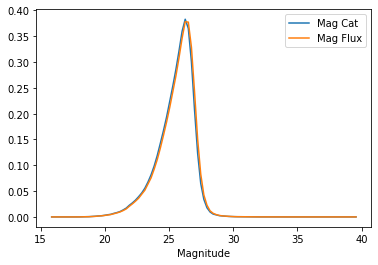

In [18]:
hist_mag_cat,_ = np.histogram(mag_cat, bins=bins, density=True)
hist_mag_flux,_ = np.histogram(mag_flux, bins=bins, density=True)

plt.plot(bin_centers, hist_mag_cat, label='Mag Cat')
plt.plot(bin_centers, hist_mag_flux, label='Mag Flux')
plt.legend()
plt.xlabel("Magnitude")
plt.show()

### Final Formatting

In [19]:
cat = cat1.copy()

In [20]:
# optional: keep only the most commonly used columns (total FLUX, error bars, RA, DEC...)
cat.keep_columns(['ID','ALPHA_J2000','DELTA_J2000']+
                 [i+flx for i in filt_use]+[i+flxerr for i in filt_use]+
                 [i+mg for i in filt_use]+[i+mgerr for i in filt_use]+
                 ['lp_zBEST','lp_model','lp_age','lp_dust','lp_Attenuation','lp_zp_2','lp_zq','lp_type']+
                 ['lp_MNUV','lp_MR','lp_MJ','lp_mass_med','lp_mass_med_min68','lp_mass_med_max68',
                  'lp_SFR_med','lp_mass_best'] + ['FLUX_RADIUS', 'KRON_RADIUS'])

In [21]:
# optional: magnitudes in AB system
m0 = +23.9  # fluxes in the catalog are in microJansky
for b in filt_use:
    mag = -2.5*np.log10(cat[b+flx].data) + m0  # log of negative flux is masked
    cat.add_column(mag.filled(np.nan),name=b+'_MAGAB')  # negative flux becomes NaN 

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


In [22]:
# flux conversion from uJy to erg/cm2/s/Hz
# if outflx=='cgs':
#     for b in filt_use:
#         cat[b+flx] *= 1e-29
#         cat[b+flx].unit = u.erg/u.cm/u.cm/u.s/u.Hz
#         cat[b+flxerr] *= 1e-29
#         cat[b+flxerr].unit = u.erg/u.cm/u.cm/u.s/u.Hz

In [23]:
cat.rename_column('lp_zBEST', 'photoz') 
cat.rename_column('ALPHA_J2000','RA')
cat.rename_column('DELTA_J2000','DEC')

In [24]:
print(cat['photoz'])

photoz
------
1.2724
2.8991
0.9599
  0.36
1.2045
0.4521
0.9492
1.3587
4.5398
1.3687
   ...
0.6841
0.4332
2.1121
0.3187
   0.0
0.5916
2.0997
0.3288
 3.091
0.3321
0.3126
Length = 723897 rows


In [25]:
# Save the re-formatted table as a FITS file. 
cat.write(dir_out+f'COSMOS2020_{catversion}_processed.fits',overwrite=True)

In [26]:
cat

ID,RA,DEC,FLUX_RADIUS,KRON_RADIUS,HSC_g_FLUX_APER3,HSC_g_FLUXERR_APER3,HSC_g_MAG_APER3,HSC_g_MAGERR_APER3,HSC_r_FLUX_APER3,HSC_r_FLUXERR_APER3,HSC_r_MAG_APER3,HSC_r_MAGERR_APER3,HSC_i_FLUX_APER3,HSC_i_FLUXERR_APER3,HSC_i_MAG_APER3,HSC_i_MAGERR_APER3,HSC_z_FLUX_APER3,HSC_z_FLUXERR_APER3,HSC_z_MAG_APER3,HSC_z_MAGERR_APER3,HSC_y_FLUX_APER3,HSC_y_FLUXERR_APER3,HSC_y_MAG_APER3,HSC_y_MAGERR_APER3,UVISTA_Y_FLUX_APER3,UVISTA_Y_FLUXERR_APER3,UVISTA_Y_MAG_APER3,UVISTA_Y_MAGERR_APER3,UVISTA_J_FLUX_APER3,UVISTA_J_FLUXERR_APER3,UVISTA_J_MAG_APER3,UVISTA_J_MAGERR_APER3,UVISTA_H_FLUX_APER3,UVISTA_H_FLUXERR_APER3,UVISTA_H_MAG_APER3,UVISTA_H_MAGERR_APER3,UVISTA_Ks_FLUX_APER3,UVISTA_Ks_FLUXERR_APER3,UVISTA_Ks_MAG_APER3,UVISTA_Ks_MAGERR_APER3,SC_B_FLUX_APER3,SC_B_FLUXERR_APER3,SC_B_MAG_APER3,SC_B_MAGERR_APER3,photoz,lp_type,lp_zp_2,lp_zq,lp_model,lp_age,lp_dust,lp_Attenuation,lp_MNUV,lp_MR,lp_MJ,lp_mass_med,lp_mass_med_min68,lp_mass_med_max68,lp_mass_best,lp_SFR_med,HSC_g_MAGAB,HSC_r_MAGAB,HSC_i_MAGAB,HSC_z_MAGAB,HSC_y_MAGAB,UVISTA_Y_MAGAB,UVISTA_J_MAGAB,UVISTA_H_MAGAB,UVISTA_Ks_MAGAB,SC_B_MAGAB
,deg,deg,pix,,uJy,uJy,mag,mag,uJy,uJy,mag,mag,uJy,uJy,mag,mag,uJy,uJy,mag,mag,uJy,uJy,mag,mag,uJy,uJy,mag,mag,uJy,uJy,mag,mag,uJy,uJy,mag,mag,uJy,uJy,mag,mag,uJy,uJy,mag,mag,,,,,,yr,,,mag,mag,mag,log(solMass),log(solMass),log(solMass),log(solMass),log(solMass/yr),,,,,,,,,,
int64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
201293,150.7533320576763,1.6033332639541444,13.3,0.0,0.029729823,0.012882759,27.739058,0.4802436,0.03745959,0.018218948,27.398775,0.4964358,0.056833226,0.022751687,26.934248,0.4041505,0.14269996,0.036349483,25.92457,0.2547745,0.054815423,0.07993955,26.934841,1.420785,-0.9609976,1.2239414,nan,nan,1.3676939,0.5927336,23.521275,0.4541499,0.120819494,0.65138984,26.242453,6.118601,-0.27539518,0.3776975,nan,nan,0.049024228,0.018503606,27.258339,0.44301844,1.2724,0,1.32,0.4,5,508800000.0,0.2,1,-16.42532,-17.97332,-18.11549,8.4021,7.98959,8.79633,8.27906,-0.19806,27.717018,27.466091,27.013494,26.01394,27.052742,nan,23.560028,26.194656,nan,27.173973
201325,150.77495649024627,1.6033965367753042,13.3,0.0,0.18722874,0.01363573,25.741396,0.08073585,0.22792952,0.019519439,25.438393,0.08742882,0.2213635,0.02408387,25.458147,0.10985369,0.24821787,0.03807386,25.323666,0.15343447,0.30096883,0.081203,25.085896,0.26288188,0.13904825,1.0236963,25.982506,7.568384,1.2103307,0.74707705,23.654055,0.6468704,0.1705901,0.84545314,25.867956,5.624728,-0.32424152,0.4396045,nan,nan,0.13184337,0.01918619,26.184536,0.17085716,2.8991,0,0.07,2.56,3,50000000.0,0.1,1,-19.94424,-20.19197,-20.18731,9.16265,8.78576,9.56211,8.51496,0.82723,25.719069,25.505499,25.537235,25.412916,25.203695,26.042086,23.69274,25.820114,nan,26.099854
201327,150.7682574751055,1.6032562440823552,3.2187054,3.5,0.120307654,0.01373154,26.221518,0.12651907,0.13596137,0.018628666,25.9993,0.13987225,0.24839686,0.024260657,25.333004,0.09861304,0.38440982,0.038632005,24.84873,0.10052389,0.46558234,0.081899635,24.612183,0.17138971,-0.44211563,0.8946109,nan,nan,1.048151,0.6687448,23.810238,0.6686291,-0.33958662,0.7092799,nan,nan,0.61039484,0.39296314,24.443615,0.7040886,0.092962,0.017452657,26.563835,0.22040702,0.9599,0,nan,2.12,2,904800000.0,0.0,0,-16.90499,-18.50634,-18.7367,8.703,8.55592,8.84238,8.71599,-0.18098,26.199266,26.066462,25.412134,24.938013,24.73001,nan,23.84894,nan,24.435972,26.479237
201359,150.7297592622903,1.6034367929494793,2.6980512,0.0,0.07510333,0.012417552,26.732628,0.18319657,0.1155463

In [27]:
n_data = len(cat)
column_names = cat.colnames
header = " "
header = header.join(column_names)
print(header)
print(np.array(cat)[n_data-1])
np.savetxt('/Users/philipp/Documents/PhD/Data/COSMOS2020_Classic_processed.cat', np.array(cat), header=header)

ID RA DEC FLUX_RADIUS KRON_RADIUS HSC_g_FLUX_APER3 HSC_g_FLUXERR_APER3 HSC_g_MAG_APER3 HSC_g_MAGERR_APER3 HSC_r_FLUX_APER3 HSC_r_FLUXERR_APER3 HSC_r_MAG_APER3 HSC_r_MAGERR_APER3 HSC_i_FLUX_APER3 HSC_i_FLUXERR_APER3 HSC_i_MAG_APER3 HSC_i_MAGERR_APER3 HSC_z_FLUX_APER3 HSC_z_FLUXERR_APER3 HSC_z_MAG_APER3 HSC_z_MAGERR_APER3 HSC_y_FLUX_APER3 HSC_y_FLUXERR_APER3 HSC_y_MAG_APER3 HSC_y_MAGERR_APER3 UVISTA_Y_FLUX_APER3 UVISTA_Y_FLUXERR_APER3 UVISTA_Y_MAG_APER3 UVISTA_Y_MAGERR_APER3 UVISTA_J_FLUX_APER3 UVISTA_J_FLUXERR_APER3 UVISTA_J_MAG_APER3 UVISTA_J_MAGERR_APER3 UVISTA_H_FLUX_APER3 UVISTA_H_FLUXERR_APER3 UVISTA_H_MAG_APER3 UVISTA_H_MAGERR_APER3 UVISTA_Ks_FLUX_APER3 UVISTA_Ks_FLUXERR_APER3 UVISTA_Ks_MAG_APER3 UVISTA_Ks_MAGERR_APER3 SC_B_FLUX_APER3 SC_B_FLUXERR_APER3 SC_B_MAG_APER3 SC_B_MAGERR_APER3 photoz lp_type lp_zp_2 lp_zq lp_model lp_age lp_dust lp_Attenuation lp_MNUV lp_MR lp_MJ lp_mass_med lp_mass_med_min68 lp_mass_med_max68 lp_mass_best lp_SFR_med HSC_g_MAGAB HSC_r_MAGAB HSC_i_MAGAB HS

In [ ]:
# prepare a reduced catalogue for eazy tests
# 2000 objects randomly selected
indices = np.random.choice(len(cat), size=2000, replace=False)
cat_reduced = cat[indices]
cat_reduced.write(dir_out+f'COSMOS2020_{catversion}_processed_reduced.fits',overwrite=True)